# RAISE the Bar: Restriction of Action Spaces for Improved Social Welfare and Equity in Traffic Management
## Random Erdős-Rényi graph experiment

### Setup and function definitions

In [1]:
# Internal modules
import itertools
import math

# External modules
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm, trange

# Own modules
import os, sys
sys.path.append(f'{os.getcwd()}/../../')

from src.environment import TrafficModel, Car, create_cars, build_network, UniformLatencyGenerator
from src.analysis import compute_regression, analyze_fairness
from src.util import change_value_of_money

plt.rcParams['text.usetex'] = True

In [2]:
def create_random_gnp_graph(number_of_nodes, p, latency_generator, *, seed=42):
    network = nx.gnp_random_graph(number_of_nodes, p, seed=seed, directed=True)

    nx.set_node_attributes(
        network,
        nx.circular_layout(network, dim=3, scale=10),
        "position",
    )

    nx.set_edge_attributes(
        network,
        {edge: latency_generator() for edge in network.edges},
        "latency_params",
    )

    return build_network(network)

In [3]:
BASE_COLOR = 'aqua'
RESTRICTION_COLOR = 'coral'
TOLLING_COLOR = 'darkred'

### Experiment

In [13]:
number_of_nodes = 50
p = 0.070711
graph_seed = 46
car_seed = 46
number_of_steps = 10000
values_of_money = [0, 1, 2, 5]
car_counts = {(23, 33): 38}

results = []
# Unrestricted
network = create_random_gnp_graph(number_of_nodes=number_of_nodes, p=p,
                                  latency_generator=UniformLatencyGenerator(a_min=3, a_max=4, b_min=2, b_max=3, c_min=1, c_max=3),
                                  seed=46)
cars = create_cars(network, car_counts=car_counts, seed=46)
change_value_of_money(cars, values_of_money)
model = TrafficModel(network, cars)
step_stats_unrestricted, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
results.append({'scenario': 'Base', 'travel_time': car_stats_unrestricted["travel_time"][-5000:].mean(), **analyze_fairness(car_stats_unrestricted)})

# Restricted
network = create_random_gnp_graph(number_of_nodes=number_of_nodes, p=p,
                                  latency_generator=UniformLatencyGenerator(a_min=3, a_max=4, b_min=2, b_max=3, c_min=1, c_max=3),
                                  seed=46)
cars = create_cars(network, car_counts=car_counts, seed=46)
model = TrafficModel(network, cars)

model.set_edge_restriction((23, 30), allowed=False)
model.cars = create_cars(network, car_counts=car_counts, seed=46)
change_value_of_money(cars, values_of_money)

step_stats_restricted, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
results.append({'scenario': 'Restriction', 'travel_time': car_stats_restricted["travel_time"][-5000:].mean(), **analyze_fairness(car_stats_restricted)})

# Tolling
network = create_random_gnp_graph(number_of_nodes=number_of_nodes, p=p,
                                  latency_generator=UniformLatencyGenerator(a_min=3, a_max=4, b_min=2, b_max=3, c_min=1, c_max=3),
                                  seed=46)
cars = create_cars(network, car_counts=car_counts, seed=46)
change_value_of_money(cars, values_of_money)
model = TrafficModel(network, cars, tolls=True, beta=0.01, R=0.1)
step_stats_tolling, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
results.append({'scenario': 'Tolling (excl. tolls)', 'travel_time': car_stats_tolling["travel_time"][-5000:].mean(), **analyze_fairness(car_stats_tolling)})
results.append({'scenario': 'Tolling (incl. tolls)', 'travel_time': car_stats_tolling["total_cost"][-5000:].mean()})

results = pd.DataFrame(results).set_index(['scenario'])

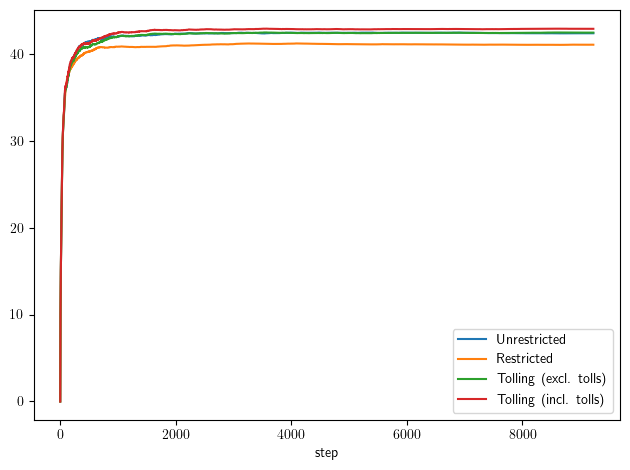

In [7]:
ax = pd.DataFrame({
    'Unrestricted': car_stats_unrestricted['travel_time'],
    'Restricted': car_stats_restricted['travel_time'],
    'Tolling (excl. tolls)': car_stats_tolling['travel_time'],
    'Tolling (incl. tolls)': car_stats_tolling['total_cost']}).expanding().mean().plot(xlabel='step')

plt.tight_layout()
ax.get_figure().savefig('test-fairness.pdf', dpi=300)

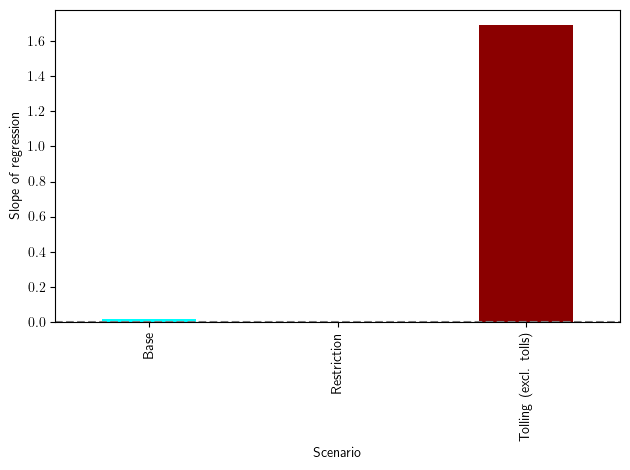

In [64]:
fairness = results['slope'].drop('Tolling (incl. tolls)', axis=0)

ax = fairness.plot(color=[BASE_COLOR, RESTRICTION_COLOR, TOLLING_COLOR], kind='bar', legend=False)
ax.set_xlabel('Scenario')
ax.set_ylabel('Slope of regression')
ax.axhline(ls='--', color='grey')

plt.tight_layout()
ax.get_figure().savefig('test-fairness.pdf', dpi=300)

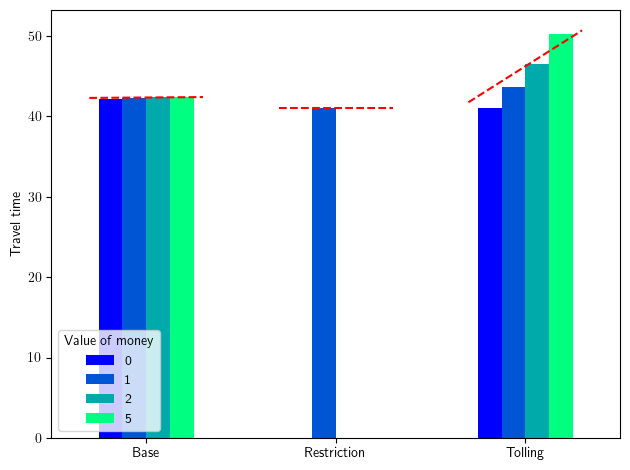

In [65]:
cutoff = 5_000

u = car_stats_unrestricted[car_stats_unrestricted['step'] >= cutoff].groupby('value_of_money')['travel_time'].mean()
r = car_stats_restricted[car_stats_restricted['step'] >= cutoff].groupby('value_of_money')['travel_time'].mean()
t = car_stats_tolling[car_stats_tolling['step'] >= cutoff].groupby('value_of_money')['travel_time'].mean()

travel_times = pd.concat([u, r, t], keys=['Base', 'Restriction', 'Tolling'], axis=1)

ax = travel_times.transpose().plot(kind='bar', cmap=mpl.colormaps['winter'])
ax.legend(loc='lower left', title='Value of money')
plt.xticks(rotation = 0)
ax.set_ylabel('Travel time')

# Add regression lines
for offset, data in enumerate([u, r, t]):
    slope, intercept, _ = compute_regression(data)
    ax.plot([offset - 0.3, offset + 0.3], [intercept + slope * min(values_of_money), intercept + slope * max(values_of_money)], 'r--')

plt.tight_layout()
ax.get_figure().savefig('braess-detailed-fairness.pdf', dpi=300)

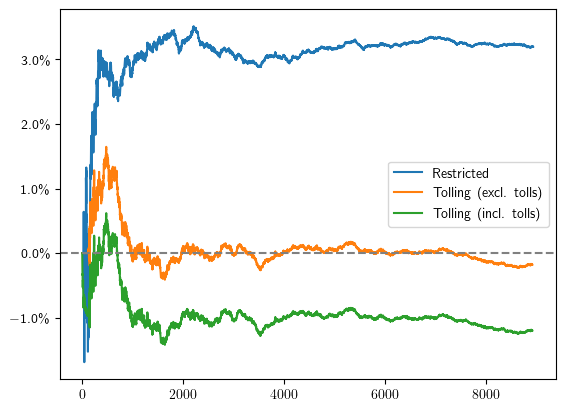

In [99]:
ax = pd.DataFrame({
    'Restricted': car_stats_unrestricted['travel_time'].expanding().mean().div(
        car_stats_restricted['travel_time'].expanding().mean()
    ).sub(1.0),
    'Tolling (excl. tolls)': car_stats_unrestricted['travel_time'].expanding().mean().div(
        car_stats_tolling['travel_time'].expanding().mean()
    ).sub(1.0),
    'Tolling (incl. tolls)': car_stats_unrestricted['travel_time'].expanding().mean().div(
        car_stats_tolling['total_cost'].expanding().mean()
    ).sub(1.0)
}).plot()
ax.axhline(ls='--', color='grey')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### Tolling Optimization

In [ ]:
from sklearn.model_selection import ParameterGrid


number_of_nodes = 50
p = 0.070711
number_of_steps = 10000
values_of_money = [0, 1, 2, 5]
car_counts = {(23, 33): 38}


def evaluate(beta, R):
    network = create_random_gnp_graph(number_of_nodes=number_of_nodes, p=p,
                                  latency_generator=UniformLatencyGenerator(a_min=3, a_max=4, b_min=2, b_max=3, c_min=1, c_max=3),
                                  seed=46)
    cars = create_cars(network, car_counts=car_counts, seed=46)
    change_value_of_money(cars, values_of_money)
    model = TrafficModel(network, cars, tolls=True, beta=beta, R=R)
    _, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=True)
    return car_stats_tolling["travel_time"][-5000:].mean()


res = []
for index, params in enumerate(ParameterGrid({
    'beta': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'R': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
})):
    print(f'Evaluating {params} ({index})')
    res.append({**params,
                'travel time': evaluate(**params)})

In [14]:
optimization_results = pd.DataFrame(res)
optimization_results

,R,beta,travel time
0,0.0,0.0001,42.3712
1,0.0,0.0005,42.3712
2,0.0,0.0010,42.3712
3,0.0,0.0050,42.3712
4,0.0,0.0100,42.3712
...,...,...,...
116,1.0,0.1000,42.4584
117,1.0,0.2000,42.6246
118,1.0,0.3000,42.4532
119,1.0,0.4000,43.0398


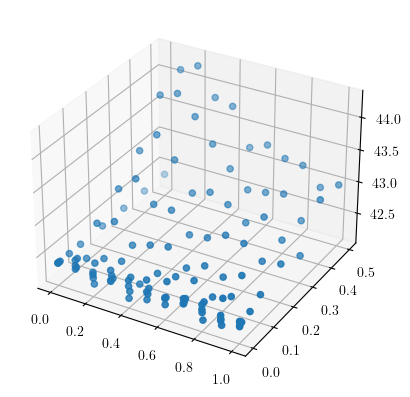

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(optimization_results['R'], optimization_results['beta'], optimization_results['travel time'])
plt.show()